In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/2024-01-18 13-19-37.csv')

In [4]:
df.columns

Index(['time', '[Clarity]Air Temp. in Vehicle (℃)',
       '[Clarity]Air Temp. Outside Vehicle (℃)',
       '[Clarity]Battery Capacity (LineB) (Ah)',
       '[Clarity]Battery Capacity (total) (Ah)',
       '[Clarity]HV Battery Voltage (LineA) (V)',
       '[Clarity]HV Battery Voltage (LineB) (V)',
       '[Clarity]HV Total Battery Current (A)',
       '[Clarity]Individual Cell Max SOC (Line A) (%)',
       '[Clarity]Individual Cell Max SOC (Line B) (%)',
       '[Clarity]Individual Cell Min SOC (Line A) (%)',
       '[Clarity]Individual Cell Min SOC (Line B) (%)', '[Clarity]SOC (%)',
       'Altitude (GPS) (feet)', 'Average speed (mph)',
       'Average speed (GPS) (mph)', 'Distance travelled (miles)',
       'Distance travelled (total) (miles)',
       'EV Instant Energy Consumption (km/kWh)',
       'EV Instant Energy Consumption [kWh/100km] (mi/kWh)',
       'HV EV Battery Power (kW)', 'Speed (GPS) (mph)',
       'Vehicle acceleration (g)', 'Vehicle speed (mph)', 'Latitude',
       

In [26]:
df.Longtitude.value_counts().loc[-104.876006]

KeyError: -104.876041

In [38]:
print(df[['time', 'Distance travelled (miles)', 'HV EV Battery Power (kW)']])

              time  Distance travelled (miles)  HV EV Battery Power (kW)
0     13:19:51.667                         NaN                       NaN
1     13:19:51.670                         NaN                       NaN
2     13:19:51.681                         NaN                       NaN
3     13:19:51.690                         NaN                       NaN
4     13:19:51.922                         NaN                       NaN
...            ...                         ...                       ...
3015  13:27:09.680                         NaN                       NaN
3016  13:27:10.679                         NaN                       NaN
3017  13:27:10.680                         NaN                       NaN
3018  13:27:11.675                         NaN                       NaN
3019  13:27:12.673                         NaN                       NaN

[3020 rows x 3 columns]


In [39]:
df[['time', 'HV EV Battery Power (kW)']][ pd.notna(df['HV EV Battery Power (kW)'])]

,time,HV EV Battery Power (kW)
11,13:19:55.426,0.424620
15,13:19:56.223,0.364500
20,13:19:56.911,0.424620
27,13:19:57.694,0.424620
30,13:19:58.498,0.391732
...,...,...
2993,13:27:01.301,0.613456
2996,13:27:02.018,0.559272
2999,13:27:02.917,0.359856
3002,13:27:03.789,0.299610


In [40]:
power_w = df[['time', 'HV EV Battery Power (kW)']][ pd.notna(df['HV EV Battery Power (kW)'])]
power_w['time'] = pd.to_datetime(power_w['time'])
power_w = power_w.to_numpy().T
power_w[1] *= 1000

In [41]:
diff = power_w[0, 1:] - power_w[0, : -1]
helper = np.vectorize(lambda x: x.total_seconds())
diff = np.vstack((helper(diff), power_w[1, :-1])).astype(np.float64)

In [42]:
# Adjust for 95% charging efficiency
diff[1] *= (np.ones_like(diff[1]) - (diff[1] < 0) * 0.05)

In [43]:
energy_used_wh = diff[0] * diff[1] / 3600
energy_used_wh = energy_used_wh.cumsum()

In [44]:
dist = df[['time', 'Distance travelled (miles)']][pd.notna(df['Distance travelled (miles)'])]
dist['time'] = pd.to_datetime(dist['time'])
dist = dist.to_numpy().T

In [45]:
energy_wh_mi = energy_used_wh[-1] / dist[1, -1]
print(f"Distance travelled: {round(dist[1, -1], 3)} mi\nEnergy efficiency: {round(energy_wh_mi, 3)} wh/mi")

Distance travelled: 2.477 mi
Energy efficiency: 237.211 wh/mi


In [12]:
acc = df[['time', 'Vehicle acceleration (g)']][pd.notna(df['Vehicle acceleration (g)'])]
acc['time'] = pd.to_datetime(acc['time'])
acc = acc.to_numpy().T

In [34]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

smooth_power_w = running_mean(power_w[1], 11)

In [30]:
power_w[1:-1,].shape

(0, 2065)

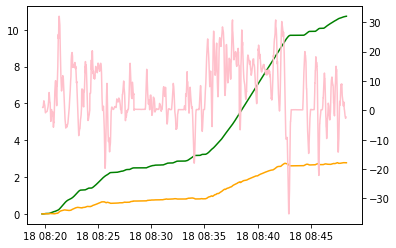

In [35]:
fig, ax1 = plt.subplots()

ax1.plot(dist[0], dist[1], 'g')
ax1.plot(power_w[0, :-1], energy_used_wh / 1000, 'orange')

ax2 = ax1.twinx()
ax2.plot(power_w[0, 5:-5], smooth_power_w / 1000, 'pink')